Stock price prediction using multivariate data(Open, High, Low, Close, Volume)

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [2]:
df = pd.read_csv('TCS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-01-01,59.987499,61.974998,59.987499,61.087502,45.255402,6027072.0
1,2003-01-02,61.525002,62.924999,57.912498,58.299999,43.190327,5325328.0
2,2003-01-03,60.000000,61.049999,58.500000,59.012501,43.718178,4198040.0
3,2003-01-06,59.924999,60.187500,56.875000,57.262501,42.421741,4121520.0
4,2003-01-07,58.000000,58.500000,56.062500,56.599998,41.930927,2650800.0


In [3]:
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace = True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2003-01-01,59.987499,61.974998,59.987499,61.087502,6027072.0
1,2003-01-02,61.525002,62.924999,57.912498,58.299999,5325328.0
2,2003-01-03,60.000000,61.049999,58.500000,59.012501,4198040.0
3,2003-01-06,59.924999,60.187500,56.875000,57.262501,4121520.0
4,2003-01-07,58.000000,58.500000,56.062500,56.599998,2650800.0


<AxesSubplot:xlabel='Date'>

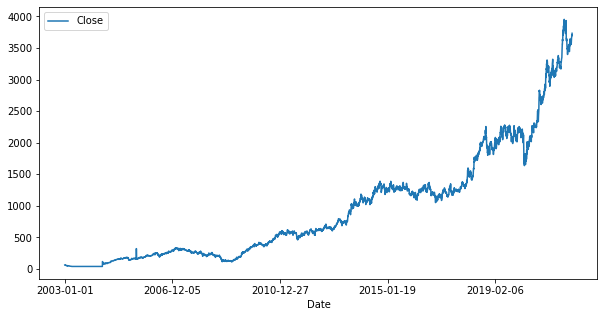

In [4]:
df.plot(x='Date', y='Close', kind='line', figsize=(10, 5))

In [5]:
dates = df.Date
df.drop(['Date'], inplace = True, axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,59.987499,61.974998,59.987499,61.087502,6027072.0
1,61.525002,62.924999,57.912498,58.299999,5325328.0
2,60.000000,61.049999,58.500000,59.012501,4198040.0
3,59.924999,60.187500,56.875000,57.262501,4121520.0
4,58.000000,58.500000,56.062500,56.599998,2650800.0


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(df)

In [7]:
scaler2 = MinMaxScaler(feature_range=(0,1))
scaler2.fit_transform(df[['Close']])

array([[0.00579649],
       [0.0050847 ],
       [0.00526664],
       ...,
       [0.9366727 ],
       [0.93364675],
       [0.94361826]])

In [8]:
data.shape

(4715, 5)

In [9]:
trainSize = int(len(data)*0.8)
testSize = len(data) - trainSize
train = data[0:trainSize]
test = data[trainSize:len(data)]

In [10]:
def modify(data, pastDays = 14):
  X = []
  Y = []
  for i in range(pastDays, len(data)):
      X.append(data[i - pastDays: i, 0: data.shape[1]])
      Y.append(data[i : i + 1, 3])
  return np.array(X), np.array(Y)

In [11]:
trainX, trainY = modify(train)
testX, testY = modify(test)

RNN

In [12]:
model1 = Sequential()
model1.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model1.add(SimpleRNN(150, return_sequences = True))
model1.add(SimpleRNN(150, return_sequences = True))
model1.add(SimpleRNN(150))
model1.add(Dense(trainY.shape[1]))
model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 14, 150)           23400     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 14, 150)           45150     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 150)               45150     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 113,851
Trainable params: 113,851
Non-trainable params: 0
_________________________________________________________________


In [13]:
model1.fit(trainX, trainY, validation_split = 0.2, epochs = 50)

Epoch 1/50
94/94 [==============================] - 28s 78ms/step - loss: 0.0899 - val_loss: 1.8447e-04
Epoch 2/50
94/94 [==============================] - 4s 39ms/step - loss: 1.8112e-04 - val_loss: 2.4131e-04
Epoch 3/50
94/94 [==============================] - 3s 37ms/step - loss: 1.1671e-04 - val_loss: 2.5731e-04
Epoch 4/50
94/94 [==============================] - 4s 37ms/step - loss: 1.0918e-04 - val_loss: 1.5852e-04
Epoch 5/50
94/94 [==============================] - 3s 36ms/step - loss: 8.5864e-05 - val_loss: 2.3407e-04
Epoch 6/50
94/94 [==============================] - 4s 38ms/step - loss: 7.4005e-05 - val_loss: 1.6872e-04
Epoch 7/50
94/94 [==============================] - 3s 32ms/step - loss: 8.5206e-05 - val_loss: 1.1218e-04
Epoch 8/50
94/94 [==============================] - 2s 17ms/step - loss: 1.0055e-04 - val_loss: 1.2868e-04
Epoch 9/50
94/94 [==============================] - 2s 16ms/step - loss: 8.4473e-05 - val_loss: 9.2243e-05
Epoch 10/50
94/94 [=====================

In [14]:
model1.save('RNN(Multi)')

INFO:tensorflow:Assets written to: RNN(Multi)\assets


Classic LSTM

In [15]:
model2 = Sequential()
model2.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model2.add(LSTM(150, return_sequences = True))
model2.add(LSTM(150, return_sequences = True))
model2.add(LSTM(150))
model2.add(Dense(trainY.shape[1]))
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 150)           93600     
                                                                 
 lstm_1 (LSTM)               (None, 14, 150)           180600    
                                                                 
 lstm_2 (LSTM)               (None, 150)               180600    
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 454,951
Trainable params: 454,951
Non-trainable params: 0
_________________________________________________________________


In [16]:
model2.fit(trainX, trainY, validation_split = 0.2, epochs = 50)

Epoch 1/50
94/94 [==============================] - 45s 285ms/step - loss: 4.0968e-04 - val_loss: 1.2163e-04
Epoch 2/50
94/94 [==============================] - 11s 117ms/step - loss: 4.0103e-05 - val_loss: 2.3577e-04
Epoch 3/50
94/94 [==============================] - 11s 116ms/step - loss: 4.2301e-05 - val_loss: 1.3051e-04
Epoch 4/50
94/94 [==============================] - 11s 114ms/step - loss: 4.0696e-05 - val_loss: 2.2979e-04
Epoch 5/50
94/94 [==============================] - 10s 112ms/step - loss: 4.5898e-05 - val_loss: 2.0262e-04
Epoch 6/50
94/94 [==============================] - 11s 113ms/step - loss: 3.9595e-05 - val_loss: 1.2419e-04
Epoch 7/50
94/94 [==============================] - 11s 115ms/step - loss: 4.4577e-05 - val_loss: 1.0700e-04
Epoch 8/50
94/94 [==============================] - 10s 111ms/step - loss: 4.6249e-05 - val_loss: 1.0653e-04
Epoch 9/50
94/94 [==============================] - 10s 111ms/step - loss: 3.3574e-05 - val_loss: 9.3404e-05
Epoch 10/50
94/94 [

In [17]:
model2.save('LSTM(Multi)')

INFO:tensorflow:Assets written to: LSTM(Multi)\assets


INFO:tensorflow:Assets written to: LSTM(Multi)\assets


LSTM Peephole

In [18]:
model3 = Sequential()
model3.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model3.add(RNN(tfa.rnn.PeepholeLSTMCell(150), return_sequences = True))
model3.add(RNN(tfa.rnn.PeepholeLSTMCell(150), return_sequences = True))
model3.add(RNN(tfa.rnn.PeepholeLSTMCell(150)))
model3.add(Dense(trainY.shape[1]))
model3.compile(optimizer='adam', loss='mse')
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 14, 150)           94050     
                                                                 
 rnn_1 (RNN)                 (None, 14, 150)           181050    
                                                                 
 rnn_2 (RNN)                 (None, 150)               181050    
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 456,301
Trainable params: 456,301
Non-trainable params: 0
_________________________________________________________________


In [19]:
model3.fit(trainX, trainY, validation_split = 0.2, epochs = 50)

Epoch 1/50
94/94 [==============================] - 92s 60ms/step - loss: 5.8774e-04 - val_loss: 1.6870e-04
Epoch 2/50
94/94 [==============================] - 5s 52ms/step - loss: 3.1932e-05 - val_loss: 1.1204e-04
Epoch 3/50
94/94 [==============================] - 5s 50ms/step - loss: 3.2681e-05 - val_loss: 1.5235e-04
Epoch 4/50
94/94 [==============================] - 5s 50ms/step - loss: 3.6359e-05 - val_loss: 1.1956e-04
Epoch 5/50
94/94 [==============================] - 5s 52ms/step - loss: 3.7383e-05 - val_loss: 1.0353e-04
Epoch 6/50
94/94 [==============================] - 5s 50ms/step - loss: 4.0393e-05 - val_loss: 3.8017e-04
Epoch 7/50
94/94 [==============================] - 5s 54ms/step - loss: 5.0702e-05 - val_loss: 1.0703e-04
Epoch 8/50
94/94 [==============================] - 5s 52ms/step - loss: 3.0056e-05 - val_loss: 1.4862e-04
Epoch 9/50
94/94 [==============================] - 5s 51ms/step - loss: 4.0830e-05 - val_loss: 1.0226e-04
Epoch 10/50
94/94 [=================

In [20]:
model3.save('PeepholeLSTM(Multi)')

INFO:tensorflow:Assets written to: PeepholeLSTM(Multi)\assets


INFO:tensorflow:Assets written to: PeepholeLSTM(Multi)\assets


Bidirectional LSTM

In [21]:
model4 = Sequential()
model4.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model4.add(Bidirectional(LSTM(150, return_sequences = True)))
model4.add(Bidirectional(LSTM(150, return_sequences = True)))
model4.add(Bidirectional(LSTM(150)))
model4.add(Dense(trainY.shape[1]))
model4.compile(optimizer='adam', loss='mse')
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 14, 300)          187200    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 14, 300)          541200    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 300)              541200    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 1,269,901
Trainable params: 1,269,901
Non-trainable params: 0
____________________________________________

In [22]:
model4.fit(trainX, trainY, validation_split = 0.2, epochs = 50)

Epoch 1/50
94/94 [==============================] - 27s 165ms/step - loss: 6.0781e-04 - val_loss: 1.0449e-04
Epoch 2/50
94/94 [==============================] - 16s 169ms/step - loss: 2.9098e-05 - val_loss: 1.0418e-04
Epoch 3/50
94/94 [==============================] - 13s 139ms/step - loss: 3.2437e-05 - val_loss: 1.9224e-04
Epoch 4/50
94/94 [==============================] - 20s 211ms/step - loss: 2.7483e-05 - val_loss: 1.2665e-04
Epoch 5/50
94/94 [==============================] - 21s 219ms/step - loss: 2.9772e-05 - val_loss: 3.4820e-04
Epoch 6/50
94/94 [==============================] - 22s 234ms/step - loss: 3.1548e-05 - val_loss: 1.3620e-04
Epoch 7/50
94/94 [==============================] - 24s 259ms/step - loss: 2.7065e-05 - val_loss: 8.6151e-05
Epoch 8/50
94/94 [==============================] - 24s 255ms/step - loss: 3.6790e-05 - val_loss: 3.3938e-04
Epoch 9/50
94/94 [==============================] - 21s 227ms/step - loss: 3.1150e-05 - val_loss: 1.0191e-04
Epoch 10/50
94/94 [

In [23]:
model4.save('BiLSTM(Multi)')

INFO:tensorflow:Assets written to: BiLSTM(Multi)\assets


INFO:tensorflow:Assets written to: BiLSTM(Multi)\assets


GRU(Gated Recurrent Unit)

In [24]:
model5 = Sequential()
model5.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model5.add(GRU(150, return_sequences = True))
model5.add(GRU(150, return_sequences = True))
model5.add(GRU(150))
model5.add(Dense(trainY.shape[1]))
model5.compile(optimizer='adam', loss='mse')
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 150)           70650     
                                                                 
 gru_1 (GRU)                 (None, 14, 150)           135900    
                                                                 
 gru_2 (GRU)                 (None, 150)               135900    
                                                                 
 dense_4 (Dense)             (None, 1)                 151       
                                                                 
Total params: 342,601
Trainable params: 342,601
Non-trainable params: 0
_________________________________________________________________


In [25]:
model5.fit(trainX, trainY, validation_split = 0.2, epochs = 50)

Epoch 1/50
94/94 [==============================] - 47s 168ms/step - loss: 6.0377e-04 - val_loss: 6.3633e-05
Epoch 2/50
94/94 [==============================] - 8s 81ms/step - loss: 1.7718e-05 - val_loss: 5.8972e-05
Epoch 3/50
94/94 [==============================] - 9s 95ms/step - loss: 2.0313e-05 - val_loss: 7.0562e-05
Epoch 4/50
94/94 [==============================] - 8s 83ms/step - loss: 1.7492e-05 - val_loss: 5.8666e-05
Epoch 5/50
94/94 [==============================] - 8s 81ms/step - loss: 1.7801e-05 - val_loss: 5.3576e-05
Epoch 6/50
94/94 [==============================] - 9s 95ms/step - loss: 1.7288e-05 - val_loss: 1.2449e-04
Epoch 7/50
94/94 [==============================] - 8s 83ms/step - loss: 1.8465e-05 - val_loss: 2.9311e-04
Epoch 8/50
94/94 [==============================] - 10s 102ms/step - loss: 1.9254e-05 - val_loss: 1.1283e-04
Epoch 9/50
94/94 [==============================] - 8s 80ms/step - loss: 1.9189e-05 - val_loss: 6.1790e-05
Epoch 10/50
94/94 [==============

In [26]:
model5.save('GRU(Multi)')

INFO:tensorflow:Assets written to: GRU(Multi)\assets


INFO:tensorflow:Assets written to: GRU(Multi)\assets


Bidirection GRU

In [27]:
model6 = Sequential()
model6.add(InputLayer((trainX.shape[1], trainX.shape[2])))
model6.add(Bidirectional(GRU(150, return_sequences = True)))
model6.add(Bidirectional(GRU(150, return_sequences = True)))
model6.add(Bidirectional(GRU(150)))
model6.add(Dense(trainY.shape[1]))
model6.compile(optimizer='adam', loss='mse')
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 14, 300)          141300    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 14, 300)          406800    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 300)              406800    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 301       
                                                                 
Total params: 955,201
Trainable params: 955,201
Non-trainable params: 0
________________________________________________

In [28]:
model6.fit(trainX, trainY, validation_split = 0.2, epochs = 50)

Epoch 1/50
94/94 [==============================] - 110s 512ms/step - loss: 5.4413e-04 - val_loss: 9.8029e-05
Epoch 2/50
94/94 [==============================] - 38s 400ms/step - loss: 2.3355e-05 - val_loss: 7.0942e-05
Epoch 3/50
94/94 [==============================] - 36s 387ms/step - loss: 2.0924e-05 - val_loss: 5.8044e-05
Epoch 4/50
94/94 [==============================] - 38s 405ms/step - loss: 1.9492e-05 - val_loss: 6.5174e-05
Epoch 5/50
94/94 [==============================] - 37s 397ms/step - loss: 1.9480e-05 - val_loss: 4.8930e-05
Epoch 6/50
94/94 [==============================] - 37s 395ms/step - loss: 1.8342e-05 - val_loss: 4.3398e-05
Epoch 7/50
94/94 [==============================] - 36s 387ms/step - loss: 1.7957e-05 - val_loss: 4.6739e-05
Epoch 8/50
94/94 [==============================] - 35s 376ms/step - loss: 1.7138e-05 - val_loss: 4.9224e-05
Epoch 9/50
94/94 [==============================] - 25s 265ms/step - loss: 1.8198e-05 - val_loss: 8.7118e-05
Epoch 10/50
94/94 

In [29]:
model6.save('BiGRU(Multi)')

INFO:tensorflow:Assets written to: BiGRU(Multi)\assets


INFO:tensorflow:Assets written to: BiGRU(Multi)\assets
